In [1]:

import requests
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
#import seaborn as sns

In [2]:

def search(entity: str, query:str) ->list:
#record file entity types: P = people, B = business, O = organisation, F = family, M = manor
    """
    Calls API and returns data

        parameters:
            (str) entity to search for
            (str) query term

        Returns:
            JSON output as list of dictionaries
    """
#have used the url to set limits on dates, to limit the size of the data returned - and to help with the pandas issue around dates (see below)
    url = 'https://discovery.nationalarchives.gov.uk/API/search/v1/fileauthorities?sps.fileAuthorityEntityTypes={}&sps.dateFrom=1750-01-01&sps.dateTo=1950-12-31&sps.searchQuery={}&sps.resultsPageSize=1000'.format(entity, query)
    response = requests.get(url)
    if response.status_code != 200: #error handling
        print(response.text)
        exit() #stop programme if response is not correct
    else:
        records = response.json()
    print('the chosen parameters to search are ', entity, 'and ', query)
    return records


In [3]:
def toDF(dfdata: list, cols: list) ->object:

    """
    create pandas dataframe from output of API call, adding in only certain columns
    :param dfdata: list of data from API call
    :param cols: list of columns to be used
    :return: pd.datafrome
    """

    df = pd.DataFrame(data=dfdata, columns=cols)
    return df

In [4]:

##Since pandas represents timestamps in nanosecond resolution, the timespan that can be represented using a 64-bit integer is limited to approximately 584 years
## This is not good for historical data - using the errors = 'coerce arguement forces the dates outside bounds to NaT
## this is not great in terms of data loss, but allows processing of the rest of the data
def getYear(df, col1: str, col2: str) -> object:

    """
    get the year from datetime
    :param df: (str) name of datafrome
    :param col1: (str) name of column with datetime
    :param col2: (str) name of column to add with Year
    :return: updated dafaframe
    """

    df[col1] = pd.to_datetime(df[col1], infer_datetime_format=True, errors='coerce')  #format='%d/%m/%Y'
    df[col2] = df[col1].dt.year #pandas allows infered datetime, which is useful with imperfectly formated data

    return df

In [5]:
def placeCount(df, col: str) ->object:

    """
    count the number of times places appear in the data
    :param df: name of dataframe to be used
    :param col: column name
    :return: new dataframe with counts of data
    """

    df[col] =df[col].astype(str) #place data is list of lists - convert to string
    #use regex to remove punctuation, split string at whitespace (default). stack() transposes the data into rows, value_counts() counts number of times each term appears
    df_places =df[col].str.replace(r'[^\w\s]+', '', regex=True).str.split(expand = True).stack().value_counts().nlargest(12) #nlargest takes the highest values
    df_places.columns = ['names', 'counts']
    return df_places


In [6]:
def SearchType(val: str, searchterm: str) ->dict:
    # val is the keys for the API - the most searchable here are title, altName and place
    """
    returns dictionary of number of times a searchterm appears in the data
    :param val: key within which to search
    :param searchterm: query term
    :return: dictionary
    """

    count_dict={}
    records = search('P', 'physicist') #call first search funtion
    authrecords = records['fileAuthorityAssets']
    for item in authrecords:
        if searchterm in item[val]: #check if searchterm is present
            count_dict[searchterm] = count_dict.get(searchterm,0)+1 #add searchterm and count to dict
            print(item['title'])
        # else:
        #     print(searchterm, ' not found')
    return count_dict


In [7]:
#call search funtion
records = search('P', 'physicist')
AuthRecords = records['fileAuthorityAssets']

#check how many records there are
print("Total authority records to be retrieved:",records["count"]) #shows total number of records, though URL has capped the size returned to 1000

the chosen parameters to search are  P and  physicist
Total authority records to be retrieved: 262


In [8]:
#show gender divide of people if using entity type P
print('If using People entity type, gender divide of data: ')
y = records['gender']
print(y)


If using People entity type, gender divide of data: 
[{'code': 'M', 'count': 256}, {'code': 'F', 'count': 6}]


In [9]:
#list of column names to pass to dataframe
ColNames = ['title','altName','places','startDate','endDate','repositoriesCount','CollectionCount',]
#call funtion to create dataframe
df = toDF(AuthRecords, ColNames)
print('showing overview of data: ')
df.head()

showing overview of data: 


,title,altName,places,startDate,endDate,repositoriesCount,CollectionCount
0,"Irons, Eric, (d 1963), Physicist",,[],01/01/1893,31/12/1963,1,NaN
1,"Freedman, Albert, (1916-2004), physicist",,[],01/01/1916,31/12/2004,1,NaN
2,"Domb, Cyril, (1920-2012), physicist",,[],01/01/1920,31/12/2012,1,NaN
3,"Keller, Andrew, (1925-1999), Physicist",,[],01/01/1925,31/12/1999,1,NaN
4,"Pontecorvo, Bruno, (1913-1993), physicist",,[],01/01/1913,31/12/1993,1,NaN


In [10]:
#call funtion to extract year from datetime in dataframe start- and end-date columns
df = getYear(df, 'startDate', 'FirstYear')
df = getYear(df, 'endDate', 'LastYear')
print('most common years: ')
df['FirstYear'].value_counts()#value_counts() counts the number of times a value appears in a column

most common years: 


1908    12
1903     8
1851     8
1911     8
1887     6
        ..
1849     1
1825     1
1871     1
1889     1
1947     1
Name: FirstYear, Length: 98, dtype: int64

In [11]:
#call function to count places in the data
df_placeNames= placeCount(df, 'places')
#This is imperfect because 'North East' for example, becomes 'North' and 'East', but still gives an approximate idea of places in the data
print('df of place names ... ')
df_placeNames.head()


df of place names ... 


Yorkshire    12
England       8
East          6
West          5
South         4
dtype: int64

graph of place-names 


<Axes: >

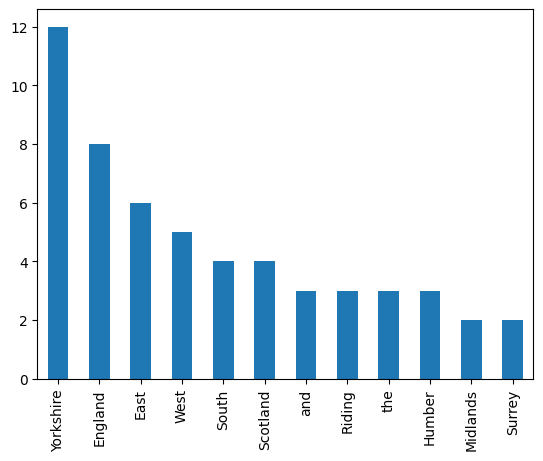

In [12]:
#create graph of place names
placedata = df_placeNames
print('graph of place-names ')
placedata.plot.bar(x='names', y='counts')

In [14]:
#call funtion to search data further with input from user
val = input('Enter parameter to search: ') #parameter is the keys for the API - the most searchable here are title, altName and place
searchterm = input('Enter search term: ')
count_term = SearchType(val,searchterm)
#check how many time the search term appeared
for key, value in count_term.items():
    print("The term", key.upper(), 'was searched for in', val.upper(), 'and appeared in', value, "instances")


Enter parameter to search: title
Enter search term: Albert
the chosen parameters to search are  P and  physicist
Freedman, Albert, (1916-2004), physicist
Einstein, Albert, (1879-1955), physicist
Kempton, Albert Ernest, (1911-2000), physicist
Wilson, Harold Albert, (1874-1964), Physicist
Boot, Henry Albert Howard, (1917-1983), physicist
The term ALBERT was searched for in TITLE and appeared in 5 instances
